In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-29 10:12:51.780768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 10:12:52.311857: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 10:12:54.157498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_154
rm: cannot remove '/kaggle/output/exp_154': No such file or directory


In [2]:
# 特徴生成
files = sorted(list(glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")))
f_files = sorted(list(glob("/kaggle/input/heauristic_features/heauristic_features/*.parquet")))
files = [(f, ff) for f, ff in zip(files, f_files)]
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [18:10<00:00,  3.94s/it] 


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,is_sleep_block_rolling_mean_5_shift_-2,is_sleep_block_rolling_mean_5_shift_-25,is_sleep_block_rolling_mean_5_shift_-5,is_sleep_block_rolling_mean_5_shift_-50,is_sleep_block_rolling_mean_5_shift_10,is_sleep_block_rolling_mean_5_shift_2,is_sleep_block_rolling_mean_5_shift_25,is_sleep_block_rolling_mean_5_shift_5,is_sleep_block_rolling_mean_5_shift_50,fold
32,-83.1250,0.432373,0.432373,-6.062500,0.015564,0.001191,0.064697,147.5,0.0,57747.5,...,0.883301,0.0,1.0,0.0,0.399902,0.083313,1.0,0.000000,NaN,2
33,-83.5625,0.067688,0.067688,-7.804688,0.014847,0.000298,0.051178,207.5,0.0,57807.5,...,1.000000,0.0,1.0,0.0,0.199951,0.283447,1.0,0.000000,NaN,2
34,-83.6250,0.067688,0.067688,-5.238281,0.015167,0.000435,0.078796,267.5,0.0,57867.5,...,1.000000,0.0,1.0,0.0,0.000000,0.483398,1.0,0.000000,NaN,2
35,-83.5000,0.114563,0.114563,-9.828125,0.014633,0.000310,0.057922,327.5,0.0,57927.5,...,1.000000,0.0,1.0,0.0,0.000000,0.683105,1.0,0.083313,NaN,2
36,-83.0625,0.072937,0.072937,-13.796875,0.017395,0.007259,0.055939,387.5,0.0,57987.5,...,1.000000,0.0,1.0,0.0,0.000000,0.883301,1.0,0.283447,NaN,2


(993599, 1735)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.03017	valid_0's l2: 1.06124
[200]	valid_0's rmse: 0.924858	valid_0's l2: 0.855363
[300]	valid_0's rmse: 0.8987	valid_0's l2: 0.807661
[400]	valid_0's rmse: 0.891062	valid_0's l2: 0.793991
[500]	valid_0's rmse: 0.888703	valid_0's l2: 0.789794
[600]	valid_0's rmse: 0.887616	valid_0's l2: 0.787863
[700]	valid_0's rmse: 0.887306	valid_0's l2: 0.787312
[800]	valid_0's rmse: 0.886856	valid_0's l2: 0.786513
[900]	valid_0's rmse: 0.886452	valid_0's l2: 0.785797
[1000]	valid_0's rmse: 0.886067	valid_0's l2: 0.785114
[1100]	valid_0's rmse: 0.885757	valid_0's l2: 0.784565
[1200]	valid_0's rmse: 0.88553	valid_0's l2: 0.784163
[1300]	valid_0's rmse: 0.885299	valid_0's l2: 0.783753
[1400]	valid_0's rmse: 0.885064	valid_0's l2: 0.783339
[1500]	valid_0's rmse: 0.884974	valid_0's l2: 0.783179
[1600]	valid_0's rmse: 0.884839	valid_0's l2: 0.782941
[1700]	valid_0's rmse: 0.884697	valid_0's l2: 0.782689
[1800]	valid_0's rmse: 0.884533	valid_0's l2: 0.782398
[1900]	vali

 20%|██        | 1/5 [04:32<18:09, 272.37s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.07627	valid_0's l2: 1.15837
[200]	valid_0's rmse: 0.978551	valid_0's l2: 0.957563
[300]	valid_0's rmse: 0.952309	valid_0's l2: 0.906892
[400]	valid_0's rmse: 0.944906	valid_0's l2: 0.892847
[500]	valid_0's rmse: 0.941807	valid_0's l2: 0.887001
[600]	valid_0's rmse: 0.940426	valid_0's l2: 0.884401
[700]	valid_0's rmse: 0.939733	valid_0's l2: 0.883099
[800]	valid_0's rmse: 0.938986	valid_0's l2: 0.881695
[900]	valid_0's rmse: 0.938373	valid_0's l2: 0.880543
[1000]	valid_0's rmse: 0.93797	valid_0's l2: 0.879788
[1100]	valid_0's rmse: 0.937529	valid_0's l2: 0.87896
[1200]	valid_0's rmse: 0.937291	valid_0's l2: 0.878515
[1300]	valid_0's rmse: 0.936977	valid_0's l2: 0.877925
[1400]	valid_0's rmse: 0.936788	valid_0's l2: 0.877572
[1500]	valid_0's rmse: 0.936575	valid_0's l2: 0.877173
[1600]	valid_0's rmse: 0.936349	valid_0's l2: 0.87675
[1700]	valid_0's rmse: 0.936104	valid_0's l2: 0.876291
[1800]	valid_0's rmse: 0.93588	valid_0's l2: 0.875871
[1900]	valid

 40%|████      | 2/5 [10:39<16:24, 328.01s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.17946	valid_0's l2: 1.39113
[200]	valid_0's rmse: 1.07718	valid_0's l2: 1.16031
[300]	valid_0's rmse: 1.0486	valid_0's l2: 1.09957
[400]	valid_0's rmse: 1.04042	valid_0's l2: 1.08248
[500]	valid_0's rmse: 1.03771	valid_0's l2: 1.07685
[600]	valid_0's rmse: 1.03656	valid_0's l2: 1.07445
[700]	valid_0's rmse: 1.03565	valid_0's l2: 1.07258
[800]	valid_0's rmse: 1.03491	valid_0's l2: 1.07104
[900]	valid_0's rmse: 1.03443	valid_0's l2: 1.07005
[1000]	valid_0's rmse: 1.03411	valid_0's l2: 1.06938
[1100]	valid_0's rmse: 1.03368	valid_0's l2: 1.0685
[1200]	valid_0's rmse: 1.03352	valid_0's l2: 1.06816
[1300]	valid_0's rmse: 1.03335	valid_0's l2: 1.06782
[1400]	valid_0's rmse: 1.03312	valid_0's l2: 1.06734
[1500]	valid_0's rmse: 1.03301	valid_0's l2: 1.06711
[1600]	valid_0's rmse: 1.03283	valid_0's l2: 1.06674
[1700]	valid_0's rmse: 1.03275	valid_0's l2: 1.06658
[1800]	valid_0's rmse: 1.03266	valid_0's l2: 1.06638
[1900]	valid_0's rmse: 1.03259	valid_0's l2:

 60%|██████    | 3/5 [15:42<10:33, 316.76s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.22282	valid_0's l2: 1.4953
[200]	valid_0's rmse: 1.10657	valid_0's l2: 1.2245
[300]	valid_0's rmse: 1.07789	valid_0's l2: 1.16184
[400]	valid_0's rmse: 1.06958	valid_0's l2: 1.14401
[500]	valid_0's rmse: 1.06665	valid_0's l2: 1.13775
[600]	valid_0's rmse: 1.06525	valid_0's l2: 1.13476
[700]	valid_0's rmse: 1.06455	valid_0's l2: 1.13326
[800]	valid_0's rmse: 1.06374	valid_0's l2: 1.13155
[900]	valid_0's rmse: 1.06282	valid_0's l2: 1.12959
[1000]	valid_0's rmse: 1.06238	valid_0's l2: 1.12865
[1100]	valid_0's rmse: 1.06204	valid_0's l2: 1.12794
[1200]	valid_0's rmse: 1.06157	valid_0's l2: 1.12692
[1300]	valid_0's rmse: 1.06124	valid_0's l2: 1.12624
[1400]	valid_0's rmse: 1.06104	valid_0's l2: 1.12581
[1500]	valid_0's rmse: 1.06074	valid_0's l2: 1.12518
[1600]	valid_0's rmse: 1.06067	valid_0's l2: 1.12502
[1700]	valid_0's rmse: 1.06043	valid_0's l2: 1.12451
[1800]	valid_0's rmse: 1.06033	valid_0's l2: 1.12429
[1900]	valid_0's rmse: 1.06024	valid_0's l2:

 80%|████████  | 4/5 [20:54<05:14, 314.70s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.13805	valid_0's l2: 1.29517
[200]	valid_0's rmse: 1.03567	valid_0's l2: 1.0726
[300]	valid_0's rmse: 1.0107	valid_0's l2: 1.02152
[400]	valid_0's rmse: 1.00453	valid_0's l2: 1.00908
[500]	valid_0's rmse: 1.00218	valid_0's l2: 1.00437
[600]	valid_0's rmse: 1.00148	valid_0's l2: 1.00296
[700]	valid_0's rmse: 1.00111	valid_0's l2: 1.00223
[800]	valid_0's rmse: 1.00056	valid_0's l2: 1.00112
[900]	valid_0's rmse: 1.00022	valid_0's l2: 1.00043
[1000]	valid_0's rmse: 0.999993	valid_0's l2: 0.999986
[1100]	valid_0's rmse: 0.999816	valid_0's l2: 0.999633
[1200]	valid_0's rmse: 0.999606	valid_0's l2: 0.999212
[1300]	valid_0's rmse: 0.999409	valid_0's l2: 0.998819
[1400]	valid_0's rmse: 0.999262	valid_0's l2: 0.998524
[1500]	valid_0's rmse: 0.999111	valid_0's l2: 0.998224
[1600]	valid_0's rmse: 0.998861	valid_0's l2: 0.997724
[1700]	valid_0's rmse: 0.998854	valid_0's l2: 0.997708
[1800]	valid_0's rmse: 0.998914	valid_0's l2: 0.99783


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.02796	valid_0's l2: 1.05671
[200]	valid_0's rmse: 0.920446	valid_0's l2: 0.847221
[300]	valid_0's rmse: 0.894357	valid_0's l2: 0.799874
[400]	valid_0's rmse: 0.887091	valid_0's l2: 0.78693
[500]	valid_0's rmse: 0.885189	valid_0's l2: 0.78356
[600]	valid_0's rmse: 0.884687	valid_0's l2: 0.782672
[700]	valid_0's rmse: 0.884143	valid_0's l2: 0.781708
[800]	valid_0's rmse: 0.883787	valid_0's l2: 0.78108
[900]	valid_0's rmse: 0.883576	valid_0's l2: 0.780706
[1000]	valid_0's rmse: 0.883197	valid_0's l2: 0.780037
[1100]	valid_0's rmse: 0.883089	valid_0's l2: 0.779846
[1200]	valid_0's rmse: 0.882876	valid_0's l2: 0.779469
[1300]	valid_0's rmse: 0.882819	valid_0's l2: 0.77937
[1400]	valid_0's rmse: 0.882656	valid_0's l2: 0.779081
[1500]	valid_0's rmse: 0.882581	valid_0's l2: 0.77895
[1600]	valid_0's rmse: 0.882399	valid_0's l2: 0.778628
[1700]	valid_0's rmse: 0.88229	valid_0's l2: 0.778436
[1800]	valid_0's rmse: 0.882292	valid_0's l2: 0.778439
[1900]	valid_0

 20%|██        | 1/5 [04:04<16:18, 244.60s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.04374	valid_0's l2: 1.08938
[200]	valid_0's rmse: 0.93222	valid_0's l2: 0.869034
[300]	valid_0's rmse: 0.902393	valid_0's l2: 0.814313
[400]	valid_0's rmse: 0.89174	valid_0's l2: 0.7952
[500]	valid_0's rmse: 0.88799	valid_0's l2: 0.788526
[600]	valid_0's rmse: 0.886367	valid_0's l2: 0.785646
[700]	valid_0's rmse: 0.885459	valid_0's l2: 0.784037
[800]	valid_0's rmse: 0.884839	valid_0's l2: 0.782941
[900]	valid_0's rmse: 0.884259	valid_0's l2: 0.781915
[1000]	valid_0's rmse: 0.883895	valid_0's l2: 0.78127
[1100]	valid_0's rmse: 0.883556	valid_0's l2: 0.780671
[1200]	valid_0's rmse: 0.883129	valid_0's l2: 0.779917
[1300]	valid_0's rmse: 0.88285	valid_0's l2: 0.779425
[1400]	valid_0's rmse: 0.882638	valid_0's l2: 0.77905
[1500]	valid_0's rmse: 0.882425	valid_0's l2: 0.778674
[1600]	valid_0's rmse: 0.882296	valid_0's l2: 0.778447
[1700]	valid_0's rmse: 0.88219	valid_0's l2: 0.778259
[1800]	valid_0's rmse: 0.88217	valid_0's l2: 0.778224


 40%|████      | 2/5 [07:58<11:54, 238.21s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.16553	valid_0's l2: 1.35846
[200]	valid_0's rmse: 1.06158	valid_0's l2: 1.12695
[300]	valid_0's rmse: 1.03462	valid_0's l2: 1.07044
[400]	valid_0's rmse: 1.02639	valid_0's l2: 1.05348
[500]	valid_0's rmse: 1.02354	valid_0's l2: 1.04764
[600]	valid_0's rmse: 1.02258	valid_0's l2: 1.04566
[700]	valid_0's rmse: 1.02167	valid_0's l2: 1.04381
[800]	valid_0's rmse: 1.02123	valid_0's l2: 1.04291
[900]	valid_0's rmse: 1.02064	valid_0's l2: 1.04171
[1000]	valid_0's rmse: 1.02027	valid_0's l2: 1.04096
[1100]	valid_0's rmse: 1.02004	valid_0's l2: 1.04048
[1200]	valid_0's rmse: 1.01968	valid_0's l2: 1.03975
[1300]	valid_0's rmse: 1.01949	valid_0's l2: 1.03935
[1400]	valid_0's rmse: 1.01927	valid_0's l2: 1.03892
[1500]	valid_0's rmse: 1.01904	valid_0's l2: 1.03845
[1600]	valid_0's rmse: 1.01899	valid_0's l2: 1.03834
[1700]	valid_0's rmse: 1.01886	valid_0's l2: 1.03808
[1800]	valid_0's rmse: 1.01881	valid_0's l2: 1.03798
[1900]	valid_0's rmse: 1.01867	valid_0's l

 60%|██████    | 3/5 [13:36<09:27, 283.94s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.23439	valid_0's l2: 1.52371
[200]	valid_0's rmse: 1.13114	valid_0's l2: 1.27947
[300]	valid_0's rmse: 1.11137	valid_0's l2: 1.23513
[400]	valid_0's rmse: 1.10607	valid_0's l2: 1.22339
[500]	valid_0's rmse: 1.1044	valid_0's l2: 1.2197
[600]	valid_0's rmse: 1.10346	valid_0's l2: 1.21762
[700]	valid_0's rmse: 1.10312	valid_0's l2: 1.21687
[800]	valid_0's rmse: 1.10289	valid_0's l2: 1.21636
[900]	valid_0's rmse: 1.10294	valid_0's l2: 1.21647


 80%|████████  | 4/5 [16:35<04:02, 242.37s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.14743	valid_0's l2: 1.3166
[200]	valid_0's rmse: 1.05201	valid_0's l2: 1.10672
[300]	valid_0's rmse: 1.03026	valid_0's l2: 1.06143
[400]	valid_0's rmse: 1.02391	valid_0's l2: 1.04839
[500]	valid_0's rmse: 1.02141	valid_0's l2: 1.04328
[600]	valid_0's rmse: 1.02064	valid_0's l2: 1.0417
[700]	valid_0's rmse: 1.02018	valid_0's l2: 1.04078
[800]	valid_0's rmse: 1.01994	valid_0's l2: 1.04028
[900]	valid_0's rmse: 1.01982	valid_0's l2: 1.04002
[1000]	valid_0's rmse: 1.01937	valid_0's l2: 1.03912
[1100]	valid_0's rmse: 1.01915	valid_0's l2: 1.03867
[1200]	valid_0's rmse: 1.01898	valid_0's l2: 1.03832
[1300]	valid_0's rmse: 1.01876	valid_0's l2: 1.03788
[1400]	valid_0's rmse: 1.0184	valid_0's l2: 1.03714
[1500]	valid_0's rmse: 1.01813	valid_0's l2: 1.03659
[1600]	valid_0's rmse: 1.01812	valid_0's l2: 1.03657
[1700]	valid_0's rmse: 1.01806	valid_0's l2: 1.03645
[1800]	valid_0's rmse: 1.01793	valid_0's l2: 1.03618
[1900]	valid_0's rmse: 1.0179	valid_0's l2: 1

100%|██████████| 5/5 [21:12<00:00, 254.56s/it]


## Dynamic-Range NMS

<AxesSubplot: >

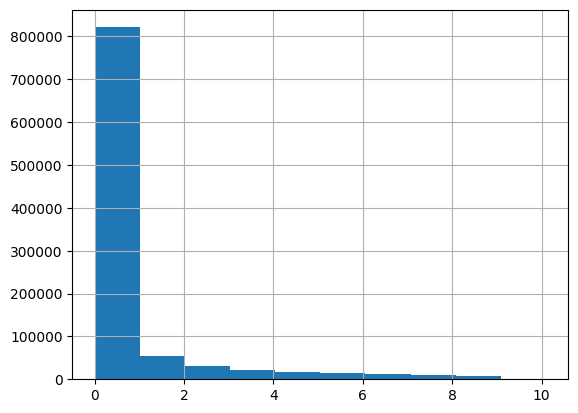

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 49.65it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7978


event   tolerance
onset   12           0.282671
        36           0.711922
        60           0.800657
        90           0.838835
        120          0.860459
        150          0.869028
        180          0.877030
        240          0.890318
        300          0.895175
        360          0.901497
wakeup  12           0.323276
        36           0.726743
        60           0.804683
        90           0.843810
        120          0.861211
        150          0.872236
        180          0.882230
        240          0.894879
        300          0.905941
        360          0.914262
dtype: float64